In [8]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from scipy.optimize import minimize

#Au material script from complex refractive index data

wvl_data = np.array([250.000000, 260.000000, 270.000000, 280.000000, 290.000000, 300.000000,
                              310.000000, 320.000000, 330.000000, 340.000000, 350.000000, 360.000000,
                              370.000000, 380.000000, 390.000000, 400.000000, 410.000000, 420.000000,
                              430.000000, 440.000000, 450.000000, 460.000000, 470.000000, 480.000000,
                              490.000000, 500.000000, 510.000000, 520.000000, 530.000000, 540.000000,
                              550.000000, 560.000000, 570.000000, 580.000000, 590.000000, 600.000000,
                              610.000000, 620.000000, 630.000000, 640.000000, 650.000000, 660.000000,
                              670.000000, 680.000000, 690.000000, 700.000000, 710.000000, 720.000000,
                              730.000000, 740.000000, 750.000000, 760.000000, 770.000000, 780.000000,
                              790.000000, 800.000000, 810.000000, 820.000000, 830.000000, 840.000000,
                              850.000000, 860.000000, 870.000000, 880.000000, 890.000000, 900.000000,
                              910.000000, 920.000000, 930.000000, 940.000000, 950.000000, 960.000000,
                              970.000000, 980.000000, 990.000000, 1000.000000])

#Refractive index data
n_data = np.array([1.486293, 1.517101, 1.602219, 1.678100, 1.750429, 1.800042, 1.830000, 1.836011,
                   1.813111, 1.781199, 1.751161, 1.726732, 1.706249, 1.687926, 1.670782, 1.658000,
                   1.641467, 1.626593, 1.607286, 1.572004, 1.503407, 1.417996, 1.315496, 1.189871,
                   1.018554, 0.849238, 0.698231, 0.571152, 0.475555, 0.397920, 0.355713, 0.318417,
                   0.295010, 0.278152, 0.261664, 0.245531, 0.229740, 0.214278, 0.199131, 0.184288,
                   0.169737, 0.164060, 0.162125, 0.160792, 0.160087, 0.160906, 0.161863, 0.162930,
                   0.164154, 0.166357, 0.168557, 0.170750, 0.172934, 0.175425, 0.178189, 0.180917,
                   0.183609, 0.186265, 0.189334, 0.193206, 0.197006, 0.200737, 0.204403, 0.208008,
                   0.211773, 0.215750, 0.219658, 0.223500, 0.227279, 0.230997, 0.234659, 0.239028,
                   0.243770, 0.248435, 0.253026, 0.257546])

#Absorption coefficient data (imaginary coefficient of complex refractive index)
k_data = np.array([1.660980, 1.759202, 1.824512, 1.873471, 1.904443, 1.919298, 1.916000, 1.897531,
                   1.870450, 1.852625, 1.847116, 1.855697, 1.883198, 1.916907, 1.939990, 1.956000,
                   1.957488, 1.949527, 1.934151, 1.910625, 1.878436, 1.843614, 1.814717, 1.799925,
                   1.820950, 1.892178, 2.027084, 2.185897, 2.374957, 2.553141, 2.695668, 2.832206,
                   2.899935, 2.930925, 2.961718, 2.992315, 3.022714, 3.052916, 3.082919, 3.112725,
                   3.142334, 3.293285, 3.477580, 3.652616, 3.817434, 3.959739, 4.097111, 4.230027,
                   4.358280, 4.474892, 4.588542, 4.699445, 4.807792, 4.914824, 5.020584, 5.124162,
                   5.225688, 5.325278, 5.419440, 5.505117, 5.589481, 5.672590, 5.754499, 5.835259,
                   5.919898, 6.009588, 6.097960, 6.185070, 6.270970, 6.355709, 6.439333, 6.519685,
                   6.597783, 6.674968, 6.751271, 6.826722])


#Fit the data to Lorentz Function and generate Au material

def lorentzfunc(p: np.ndarray, x: np.ndarray) -> np.ndarray:
    """
    Returns the complex ε profile given a set of Lorentzian parameters p
    (σ_0, ω_0, γ_0, σ_1, ω_1, γ_1, ...) for a set of frequencies x.
    """
    N = len(p) // 3
    y = np.zeros(len(x))
    for n in range(N):
        A_n, x_n, g_n = p[3 * n : 3 * n + 3]
        y = y + A_n / (np.square(x_n) - np.square(x) - 1j * x * g_n)
    return y


def lorentzerr(p: np.ndarray, x: np.ndarray, y: np.ndarray) -> float:
    """
    Returns the error (or residual or loss) as the L2 norm
    of the difference of ε(p,x) and y over a set of frequencies x.
    """
    yp = lorentzfunc(p, x)
    val = np.sum(np.square(abs(y - yp)))
    return val


def lorentzfit(
    p0: np.ndarray,
    x: np.ndarray,
    y: np.ndarray,
    tol: float = 1e-25,
    maxeval: float = 10000,
) -> Tuple[np.ndarray, float]:
    """
    Returns the optimal Lorentzian polarizability parameters and error
    which minimize the error in ε(p0,x) relative to y for an initial
    set of Lorentzian polarizability parameters p0 over a set of
    frequencies x using the scipy.optimize algorithm for a relative
    tolerance tol and a maximum number of iterations maxeval.
    """
    result = minimize(
        lambda p: lorentzerr(p, x, y),
        p0,
        method="L-BFGS-B",
        options={"ftol": tol, "maxiter": maxeval},
    )
    popt = result.x
    minf = result.fun
    return popt, minf


if __name__ == "__main__":
    
    n = n_data[:] + 1j * k_data[:]
    eps_inf = 1.1

    eps = np.square(n) - eps_inf

    wl = wvl_data[:]
    wl_min = 250  # minimum wavelength (units of nm)
    wl_max = 1000  # maximum wavelength (units of nm)
    start_idx = np.where(wl > wl_min)
    idx_start = start_idx[0][0]
    end_idx = np.where(wl < wl_max)
    idx_end = end_idx[0][-1] + 1

    # The fitting function is ε(f) where f is the frequency, rather than ε(λ).
    freqs = 1000 / wl  # units of 1/μm
    freqs_reduced = freqs[idx_start:idx_end]
    wl_reduced = wl[idx_start:idx_end]
    eps_reduced = eps[idx_start:idx_end]

    # Fitting parameter: number of Lorentzian terms to use in the fit
    num_lorentzians = 2

    # Number of times to repeat local optimization with random initial values.
    num_repeat = 30

    ps = np.zeros((num_repeat, 3 * num_lorentzians))
    mins = np.zeros(num_repeat)
    for m in range(num_repeat):
        # Initial values for the Lorentzian polarizability terms. Each term
        # consists of three parameters (σ, ω, γ) and is chosen randomly.
        # Note: for the case of no absorption, γ should be set to zero.
        p_rand = [10 ** (np.random.random()) for _ in range(3 * num_lorentzians)]
        ps[m, :], mins[m] = lorentzfit(p_rand, freqs_reduced, eps_reduced, 1e-25, 50000)
        ps_str = "( " + ", ".join(f"{prm:.4f}" for prm in ps[m, :]) + " )"
        print(f"iteration:, {m:3d}, ps_str, {mins[m]:.6f}")

    # Find the best performing set of parameters.
    idx_opt = np.argmin(mins)
    popt_str = "( " + ", ".join(f"{prm:.4f}" for prm in ps[idx_opt]) + " )"
    print(f"optimal:, {popt_str}, {mins[idx_opt]:.6f}")

    # Define a `Medium` class object using the optimal fitting parameters.
    E_susceptibilities = []

    for n in range(num_lorentzians):
        mymaterial_freq, mymaterial_gamma = ps[idx_opt][3 * n + 1:3 * n + 3]

        if mymaterial_freq == 0:
            mymaterial_sigma = ps[idx_opt][3 * n + 0]
            E_susceptibilities.append(
                mp.DrudeSusceptibility(
                    frequency=1.0, gamma=mymaterial_gamma, sigma=mymaterial_sigma
                )
            )
        else:
            mymaterial_sigma = ps[idx_opt][3 * n + 0] / mymaterial_freq**2
            E_susceptibilities.append(
                mp.LorentzianSusceptibility(
                    frequency=mymaterial_freq,
                    gamma=mymaterial_gamma,
                    sigma=mymaterial_sigma,
                )
            )

    Au = mp.Medium(epsilon=eps_inf, E_susceptibilities=E_susceptibilities)
    

TypeError: 'numpy.float64' object is not callable

In [9]:
#Sphere field enhancement

import meep as mp
import numpy as np
import matplotlib.pyplot as plt


def get_incident_value(cell_size, resolution, sources, pml_layers, d, runtime):

    print("$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$")
    
    default_material = mp.Medium(index=1.3325)

    resolution = 4/r

    sim = mp.Simulation(
            resolution=resolution,
            cell_size=cell_size,
            boundary_layers=pml_layers,
            sources=sources,
            k_point=mp.Vector3()
        )
    
    sim.run(until=runtime) #10 fs

    d=0.3*d
    
    Ez_data_1D = np.absolute(sim.get_array(center=mp.Vector3(), size=mp.Vector3(y=d), component=mp.Ey))

    return Ez_data_1D[0]
    

def get_sphere_enhancement(r, wvl, index, r_min):

    #Set time to run:
    if index > 1:
        v = 0.2254078632 #speed of light in water, in micrometres per femtosecond
        dx =  3*r - 3*r_min #difference in source position between original and new cell.
        dt = dx/v
        runtime = 10 + dt

    else:
        runtime = 10

    
    #default medium is water
    default_material = mp.Medium(index=1.3325)
    
    frq = 1 / wvl

    #4no of px per radii
    resolution = 100/r
    
    dpml = 2*r
    dair = 2*r
    #defining gap between spheres. Can adjust later.
    
    pml_layers = [mp.PML(thickness=dpml)]
    
    #Fine to keep these since the system is still symmetric relative to these planes.
    #symmetries = [mp.Mirror(mp.Y)]

    s = 2 * (dpml + dair + r)
    cell_size = mp.Vector3(s,s)
    
    # is_integrated=True necessary for any planewave source extending into PML
    sources = [
        mp.Source(
            mp.ContinuousSource(frequency=frq, is_integrated=True),
            center=mp.Vector3(-0.5*s + dpml),
            size=mp.Vector3(0, s),
            component=mp.Hz,
        )
    ]
    
    
    
    geometry = [
        mp.Sphere(material=Au,
                  center=mp.Vector3(),
                  radius=r,)
    ]
    
    
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=mp.Vector3(),
        geometry=geometry,
    )
    
    
    sim.run(until=runtime) #fs
    
    #grab data once run is finished i.e. what the system looks like at 200fs:
    d = 0.95*(s-2*dpml)

    #care only for line through each sphere to look at inter sphere enhancement
    Ez_data_1D = np.absolute(sim.get_array(center=mp.Vector3(), size=mp.Vector3(y=d), component=mp.Ey))

    incident_field_value = get_incident_value(cell_size, resolution, sources, pml_layers,d, runtime)

    eps_data_x = sim.get_array(center=mp.Vector3(), size=mp.Vector3(d, d), component=mp.Dielectric)
    Ex_data = np.absolute(sim.get_array(center=mp.Vector3(), size=mp.Vector3(d, d), component=mp.Ey))

    return Ez_data_1D, incident_field_value, Ex_data, eps_data_x



In [10]:
wvl = 535E-3

E_data = []  #Going to append all raw sim data arrays, to process and plot after the runs
inc_field_vals = []
E_data_vis = []
eps_data_vis = []

r_min =10E-3
r_max =130E-3
radii = np.linspace(r_min, r_max,20)

index = 1

for r in radii:
    print(f"##################### Run {index} Starting #######################")
    E_strength, inc_field_val, Ex_data, eps_data_x = get_sphere_enhancement(r, wvl, index, r_min)
    #E_strength = E_strength[:-2] #keep all except last two weird elements
    E_data.append(E_strength)
    inc_field_vals.append(inc_field_val)
    E_data_vis.append(Ex_data)
    eps_data_vis.append(eps_data_x)

    index += 1


##################### Run 1 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00111604 s
Working in 2D dimensions.
Computational cell is 0.1 x 0.1 x 0 with resolution 10000
     sphere, center = (0,0,0)
          radius 0.01
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.959522 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.01195/10.0 = 0.1% done in 4.0s, 3347.6s to go
on time step 239 (time=0.01195), 0.016758 s/step
Meep progress: 0.02415/10.0 = 0.2% done in 8.0s, 3308.8s to go
on time step 483 (time=0.02415), 0.0164102 s/step
Meep progress: 0.036000000000000004/10.0 = 0.4% done in 12.0s, 3326.9s to go
on time step 720 (time=0.036), 0.0169155 s/step
Meep progress: 0.048/10.0 = 0.5% done in 16.0s, 3321.6s to go
on time step 960 (time=0.048), 0.0166671 s/step
Meep progress: 0.0600000000

run 0 finished at t = 10.085197368421053 (4945 timesteps)
##################### Run 3 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00181198 s
Working in 2D dimensions.
Computational cell is 0.226316 x 0.226316 x 0 with resolution 4418.6
     sphere, center = (0,0,0)
          radius 0.0226316
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.83939 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.010976315789473686/10.168116303948466 = 0.1% done in 4.0s, 3710.8s to go
on time step 97 (time=0.0109763), 0.0413444 s/step
Meep progress: 0.02331052631578948/10.168116303948466 = 0.2% done in 8.0s, 3497.3s to go
on time step 206 (time=0.0233105), 0.036917 s/step
Meep progress: 0.035418421052631585/10.168116303948466 = 0.3% done in 12.0s, 3445.4s to go
on time step 313 (time=0.0354184), 0.03742

run 0 finished at t = 10.16814210526316 (89858 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000118971 s
Working in 2D dimensions.
Computational cell is 0.226316 x 0.226316 x 0 with resolution 176.744
time for set_epsilon = 0.0039959 s
-----------
run 0 finished at t = 10.170065789473686 (3595 timesteps)
##################### Run 4 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00139284 s
Working in 2D dimensions.
Computational cell is 0.289474 x 0.289474 x 0 with resolution 3454.55
     sphere, center = (0,0,0)
          radius 0.0289474
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.55917 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.023013157894736843/10.252174455922697

run 0 finished at t = 10.420307894736842 (50123 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000164032 s
Working in 2D dimensions.
Computational cell is 0.415789 x 0.415789 x 0 with resolution 96.2025
time for set_epsilon = 0.00293088 s
-----------
run 0 finished at t = 10.420723684210527 (2005 timesteps)
##################### Run 7 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00113106 s
Working in 2D dimensions.
Computational cell is 0.478947 x 0.478947 x 0 with resolution 2087.91
     sphere, center = (0,0,0)
          radius 0.0478947
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.96875 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.03496315789473684/10.50434891184539

run 0 finished at t = 10.588671052631579 (39065 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000101089 s
Working in 2D dimensions.
Computational cell is 0.542105 x 0.542105 x 0 with resolution 73.7864
time for set_epsilon = 0.00349808 s
-----------
run 0 finished at t = 10.59138157894737 (1563 timesteps)
##################### Run 9 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00102401 s
Working in 2D dimensions.
Computational cell is 0.605263 x 0.605263 x 0 with resolution 1652.17
     sphere, center = (0,0,0)
          radius 0.0605263
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.89178 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.047513157894736854/10.67246521579386

run 0 finished at t = 10.672605263157898 (35266 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000146151 s
Working in 2D dimensions.
Computational cell is 0.605263 x 0.605263 x 0 with resolution 66.087
time for set_epsilon = 0.00465989 s
-----------


run 0 finished at t = 10.675328947368422 (1411 timesteps)
##################### Run 10 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00130296 s
Working in 2D dimensions.
Computational cell is 0.668421 x 0.668421 x 0 with resolution 1496.06
     sphere, center = (0,0,0)
          radius 0.0668421
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.83384 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.05347368421052632/10.756523367768093 = 0.5% done in 4.0s, 802.6s to go
on time step 160 (time=0.0534737), 0.0250623 s/step
Meep progress: 0.10962105263157895/10.756523367768093 = 1.0% done in 8.0s, 779.9s to go
on time step 328 (time=0.109621), 0.0239249 s/step
Meep progress: 0.1624263157894737/10.756523367768093 = 1.5% done in 12.1s, 787.2s to go
on time step 486 (time=0.162426), 0.0255629 s

run 0 finished at t = 10.756565789473685 (32185 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000154972 s
Working in 2D dimensions.
Computational cell is 0.668421 x 0.668421 x 0 with resolution 59.8425
time for set_epsilon = 0.00403404 s
-----------
run 0 finished at t = 10.761578947368422 (1288 timesteps)
##################### Run 11 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00113893 s
Working in 2D dimensions.
Computational cell is 0.731579 x 0.731579 x 0 with resolution 1366.91
     sphere, center = (0,0,0)
          radius 0.0731579
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.87726 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.04608947368421052/10.8405815197423

##################### Run 16 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00125599 s
Working in 2D dimensions.
Computational cell is 1.04737 x 1.04737 x 0 with resolution 954.774
     sphere, center = (0,0,0)
          radius 0.104737
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.09926 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.07855263157894737/11.260872279613489 = 0.7% done in 4.0s, 572.5s to go
on time step 150 (time=0.0785526), 0.0268111 s/step
Meep progress: 0.16181842105263158/11.260872279613489 = 1.4% done in 8.0s, 551.7s to go
on time step 309 (time=0.161818), 0.0252875 s/step
Meep progress: 0.24141842105263162/11.260872279613489 = 2.1% done in 12.1s, 550.3s to go
on time step 461 (time=0.241418), 0.0263902 s/step
Meep progress: 0.32363684210526317/11.260872279613489 

run 0 finished at t = 11.345136842105264 (20432 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.00011301 s
Working in 2D dimensions.
Computational cell is 1.11053 x 1.11053 x 0 with resolution 36.019
time for set_epsilon = 0.00382495 s
-----------
run 0 finished at t = 11.355131578947368 (818 timesteps)


##################### Run 18 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00124598 s
Working in 2D dimensions.
Computational cell is 1.17368 x 1.17368 x 0 with resolution 852.018
     sphere, center = (0,0,0)
          radius 0.117368
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.16151 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.0862657894736842/11.428988583561955 = 0.8% done in 4.0s, 528.5s to go
on time step 147 (time=0.0862658), 0.0273453 s/step
Meep progress: 0.17722631578947368/11.428988583561955 = 1.6% done in 8.0s, 509.4s to go
on time step 302 (time=0.177226), 0.025821 s/step
Meep progress: 0.2658394736842105/11.428988583561955 = 2.3% done in 12.0s, 506.0s to go
on time step 453 (time=0.265839), 0.0266581 s/step
Meep progress: 0.3556263157894737/11.428988583561955 = 3.

run 0 finished at t = 11.429336842105263 (19476 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000208855 s
Working in 2D dimensions.
Computational cell is 1.17368 x 1.17368 x 0 with resolution 34.0807
time for set_epsilon = 0.00405288 s
-----------
run 0 finished at t = 11.443421052631578 (780 timesteps)
##################### Run 19 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.0013051 s
Working in 2D dimensions.
Computational cell is 1.23684 x 1.23684 x 0 with resolution 808.511
     sphere, center = (0,0,0)
          radius 0.123684
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.1668 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.09894736842105263/11.513046735536186 = 0.9

run 0 finished at t = 11.513144736842106 (18617 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000123978 s
Working in 2D dimensions.
Computational cell is 1.23684 x 1.23684 x 0 with resolution 32.3404
time for set_epsilon = 0.00318885 s
-----------
run 0 finished at t = 11.51809210526316 (745 timesteps)
##################### Run 20 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00124002 s
Working in 2D dimensions.
Computational cell is 1.3 x 1.3 x 0 with resolution 769.231
     sphere, center = (0,0,0)
          radius 0.13
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.01298 s
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
-----------
Meep progress: 0.09750000000000002/11.597104887510419 = 0.8% done in 4

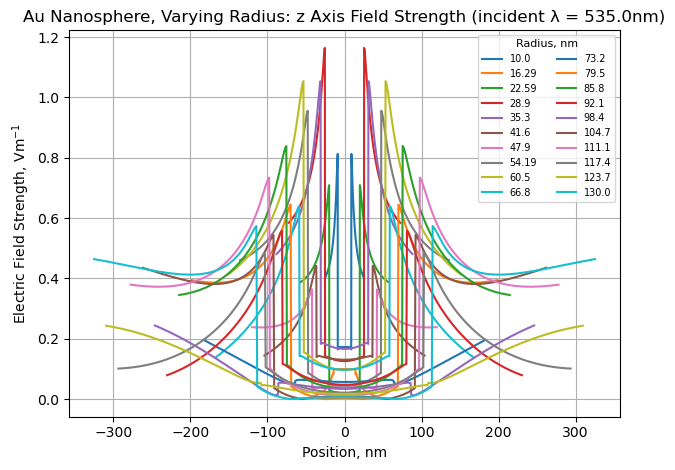

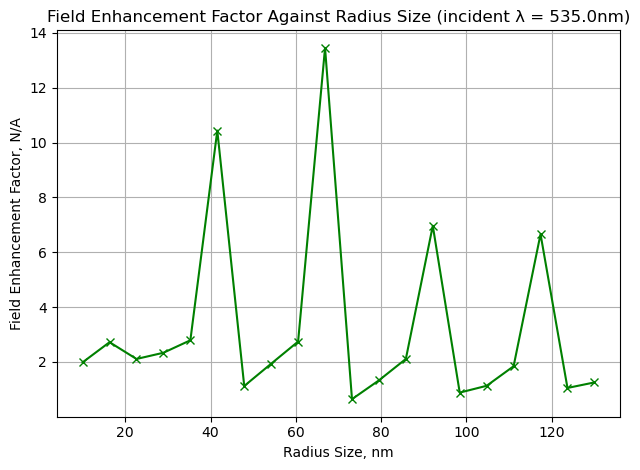

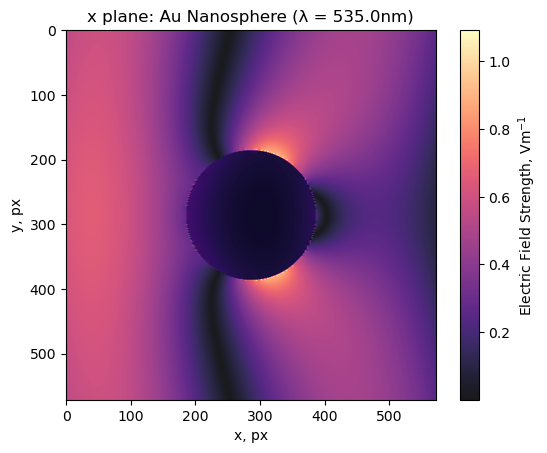

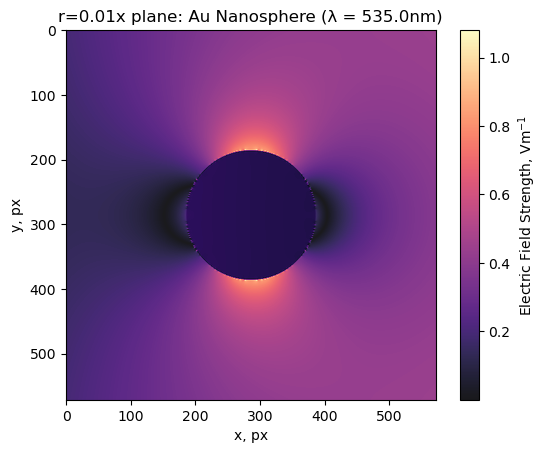

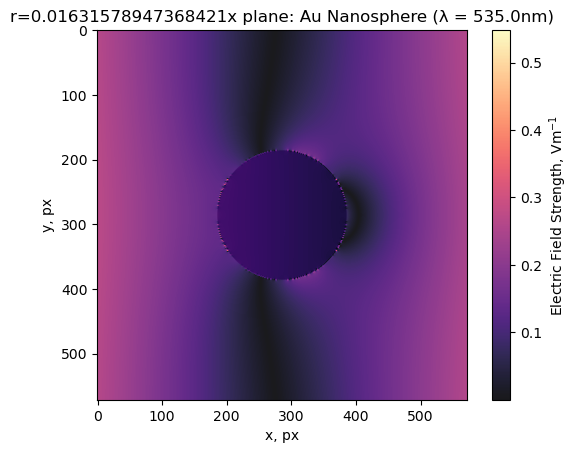

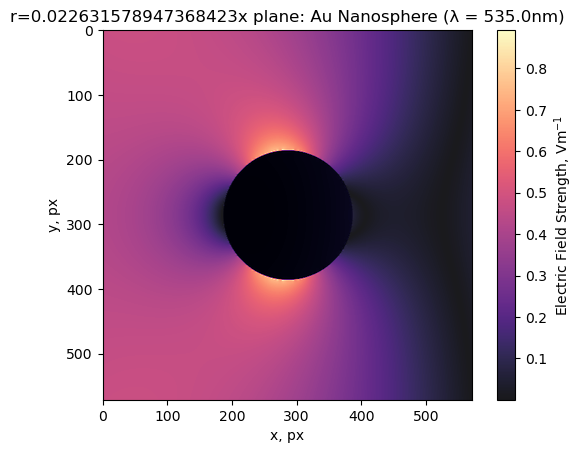

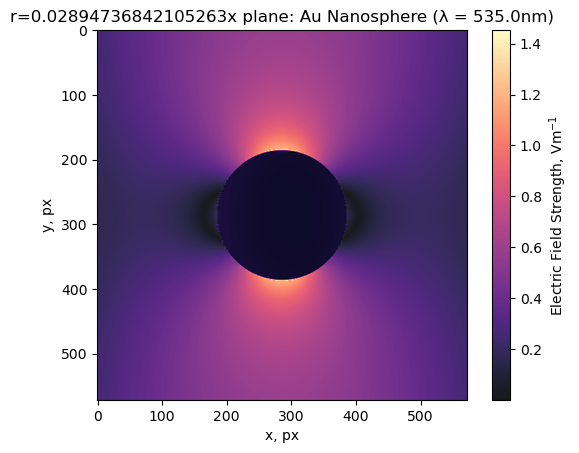

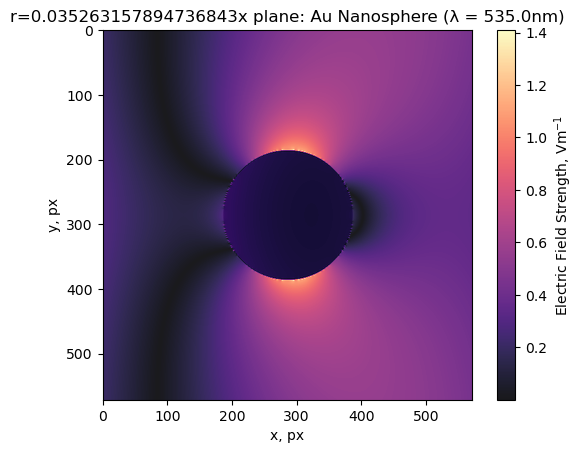

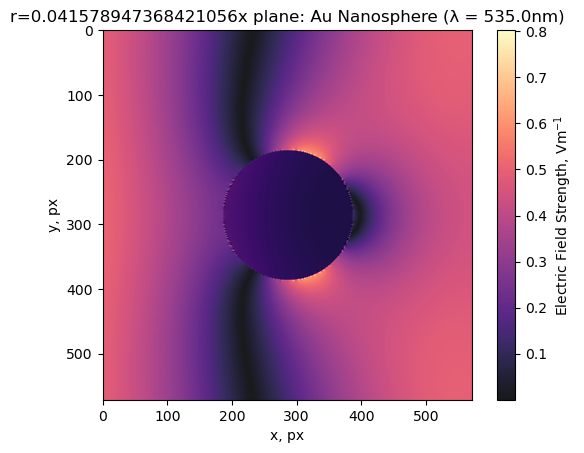

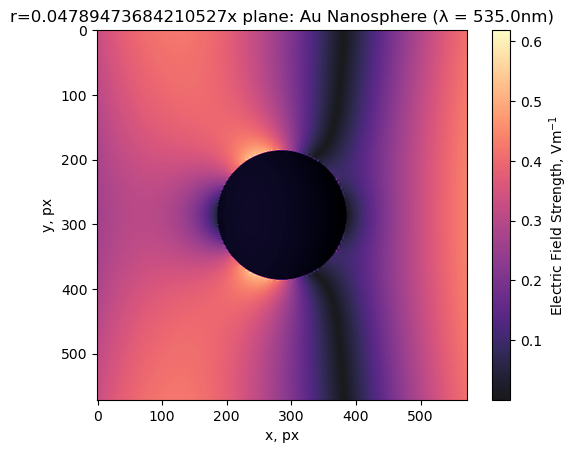

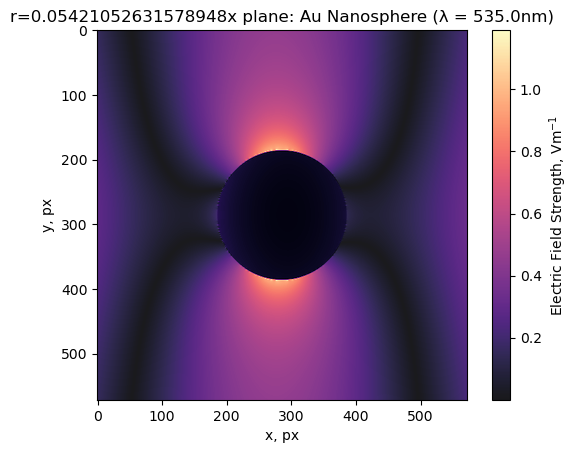

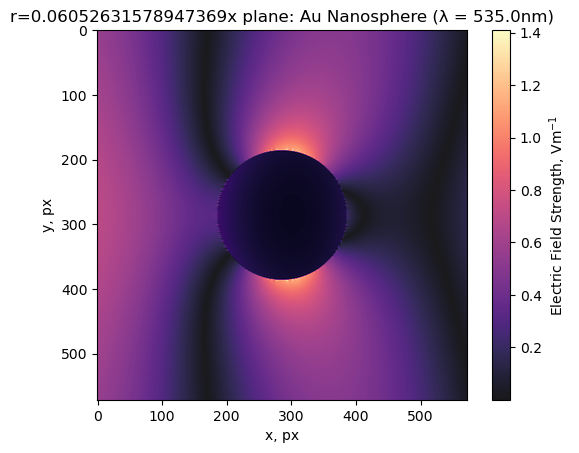

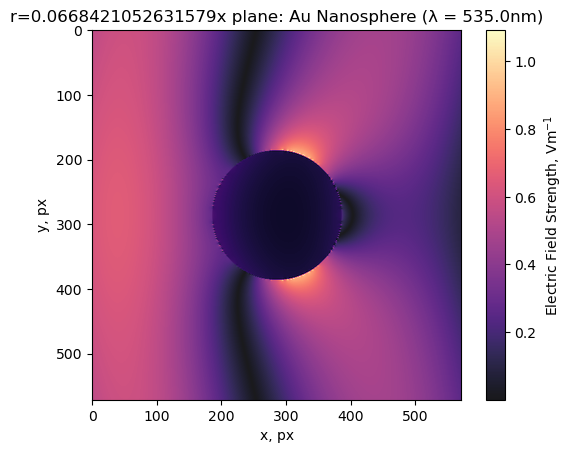

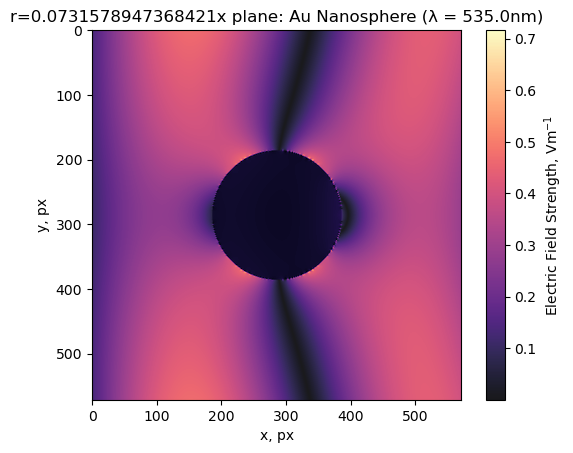

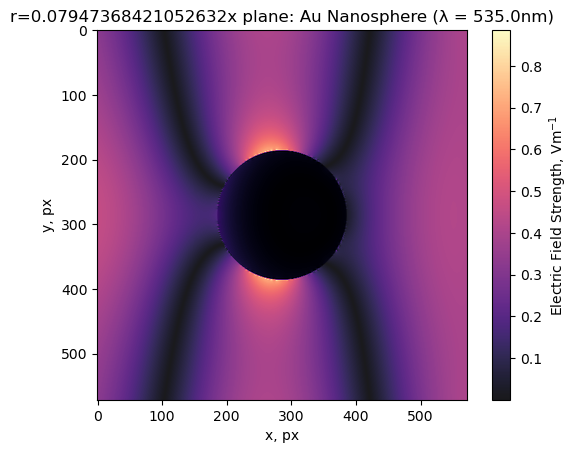

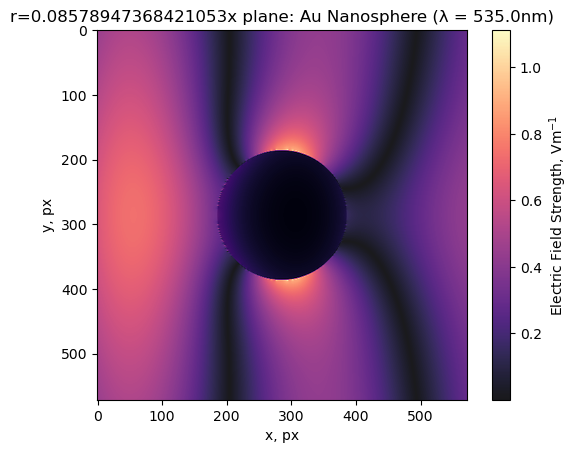

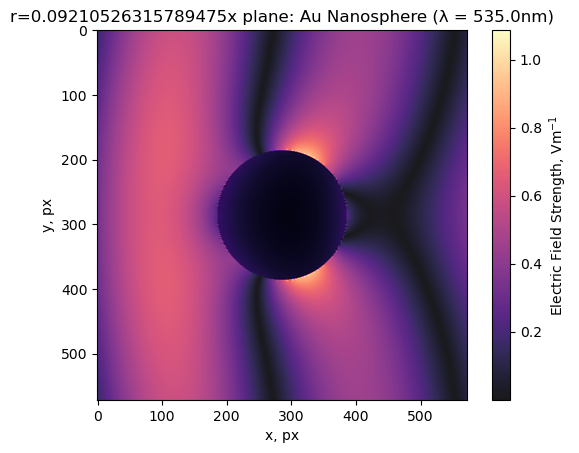

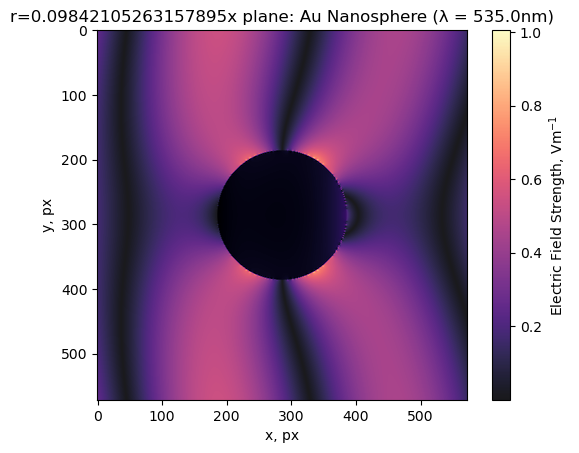

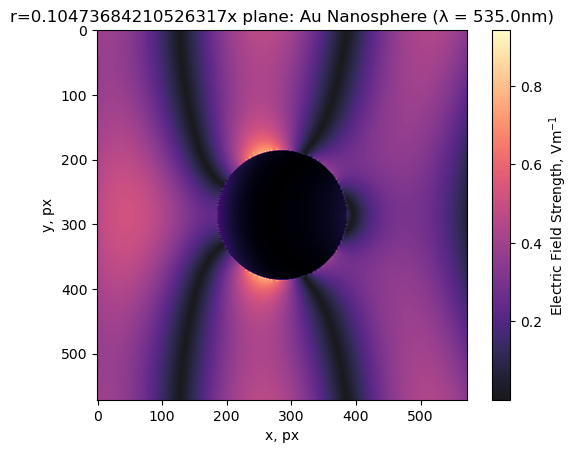

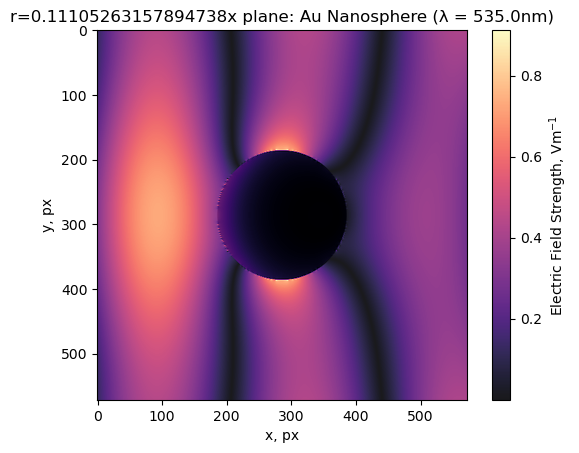

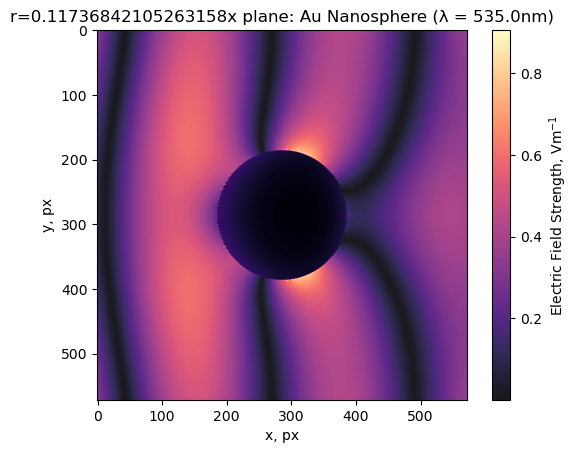

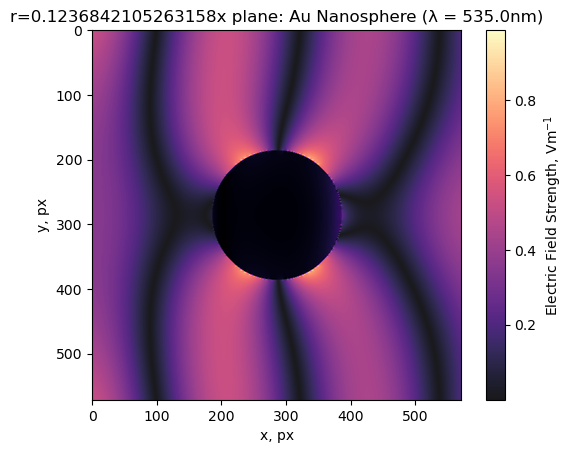

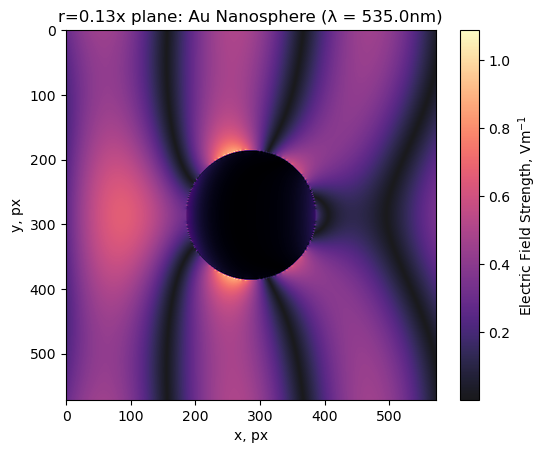

In [12]:
FEF_values = []

index = 0

for run in E_data:
    
    E_strength = run
    
    pixels = len(E_data[index])
    range = radii[index]*5/2
    space_1D = 1E3*(np.linspace(-range, +range, pixels))

    FEF_values.append(np.max(E_strength) / inc_field_vals[index])

    plt.plot(space_1D, E_strength, "-", label=f"{str(1E3*round(float(radii[index]),4))[:5]}")
    plt.grid(True, which="both", ls="-")
    plt.xlabel("Position, nm")
    plt.ylabel("Electric Field Strength, Vm$^{-1}$")
    plt.title(f"Au Nanosphere, Varying Radius: z Axis Field Strength (incident λ = {wvl*1E3}nm)")
    plt.legend(loc="upper right", title = "Radius, nm", fontsize = 7, title_fontsize= 8, ncol=2)
    plt.tight_layout()
    #plt.show()
    
    index+=1

plt.savefig(fname="Au Nanosphere, Varying Radius: z Axis Field Strength",
            dpi=150, 
            bbox_inches="tight")

plt.figure()
plt.plot(1E3*radii, FEF_values, "x-g")
plt.grid(True, which="both", ls="-")
plt.xlabel("Radius Size, nm")
plt.ylabel("Field Enhancement Factor, N/A")
plt.title(f"Field Enhancement Factor Against Radius Size (incident λ = {wvl*1E3}nm)")
plt.tight_layout()

plt.savefig(fname="Field Enhancement Factor Against Radius Size",
            dpi=150, 
            bbox_inches="tight")
plt.show()

#Now just visualise the sphere with greatest enhancement.

index_largest_enhancement = np.argmax(FEF_values)

plt.figure()
plt.imshow(eps_data_vis[index_largest_enhancement].transpose(), interpolation='spline36', cmap='binary')
plt.imshow(E_data_vis[index_largest_enhancement].transpose(), interpolation='spline36', cmap='magma', alpha=0.9)#, vmin=vmin)
colorbar = plt.colorbar()
colorbar.set_label("Electric Field Strength, Vm$^{-1}$")

plt.xlabel("x, px")
plt.ylabel("y, px")
plt.title(f"x plane: Au Nanosphere (λ = {1E3*wvl}nm)")

plt.savefig(fname="Field visualisation maximum enhancement",
        dpi=150, 
        bbox_inches="tight")
plt.show()




vmax = 0.75

for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]:
    plt.figure()
    plt.imshow(eps_data_vis[i].transpose(), interpolation='spline36', cmap='binary')
    plt.imshow(E_data_vis[i].transpose(), interpolation='spline36', cmap='magma', alpha=0.9)
    colorbar = plt.colorbar()
    colorbar.set_label("Electric Field Strength, Vm$^{-1}$")
    
    plt.xlabel("x, px")
    plt.ylabel("y, px")
    plt.title(f"r={radii[i]}x plane: Au Nanosphere (λ = {1E3*wvl}nm)")
    plt.savefig(fname=f"Field visualisation {i}",
        dpi=150, 
        bbox_inches="tight")
    plt.show()



In [14]:
print(1E3*radii, FEF_values)

[ 10.          16.31578947  22.63157895  28.94736842  35.26315789
  41.57894737  47.89473684  54.21052632  60.52631579  66.84210526
  73.15789474  79.47368421  85.78947368  92.10526316  98.42105263
 104.73684211 111.05263158 117.36842105 123.68421053 130.        ] [1.9857306967996533, 2.720433687819678, 2.108252350302125, 2.335381354660507, 2.790078754697819, 10.440598798294216, 1.122427285467136, 1.9359754006810024, 2.743015424722482, 13.456151137561392, 0.6423053711886014, 1.3280676534599145, 2.109319224115771, 6.9670168888849515, 0.8814059009450886, 1.1299708462608806, 1.8432222319388019, 6.661395957543481, 1.0511229084451608, 1.25291839570387]


In [ ]:
#Sphere field enhancement. Having a zero y axis.

import meep as mp
import numpy as np
import matplotlib.pyplot as plt


def get_incident_value(cell_size, resolution, sources, pml_layers, d, runtime):

    print("$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$")
    
    default_material = mp.Medium(index=1.3325)

    resolution = 4/r

    sim = mp.Simulation(
            resolution=resolution,
            cell_size=cell_size,
            boundary_layers=pml_layers,
            sources=sources,
            k_point=mp.Vector3()
        )
    
    sim.run(until=runtime) #10 fs

    d=0.3*d
    
    Ez_data_1D = np.absolute(sim.get_array(center=mp.Vector3(), size=mp.Vector3(z=d), component=mp.Ez))

    return Ez_data_1D[0]
    

def get_sphere_enhancement(r, wvl, index, r_min):

    #Set time to run:
    if index > 1:
        v = 0.2254078632 #speed of light in water, in micrometres per femtosecond
        dx =  3*r - 3*r_min #difference in source position between original and new cell.
        dt = dx/v
        runtime = 10 + dt

    else:
        runtime = 10

    
    #default medium is water
    default_material = mp.Medium(index=1.3325)
    
    frq = 1 / wvl

    #4no of px per radii
    resolution = 10/r
    
    dpml = 2*r
    dair = 2*r
    #defining gap between spheres. Can adjust later.
    
    pml_layers = [mp.PML(thickness=dpml)]
    
    #Fine to keep these since the system is still symmetric relative to these planes.
    symmetries = [mp.Mirror(mp.Y)]

    s = 2 * (dpml + dair + r)
    cell_size = mp.Vector3(s,0,s)
    
    # is_integrated=True necessary for any planewave source extending into PML
    sources = [
        mp.Source(
            mp.ContinuousSource(frequency=frq, is_integrated=True),
            center=mp.Vector3(-0.5*s + dpml),
            size=mp.Vector3(0, 0, s),
            component=mp.Ez,
        )
    ]
    
    
    
    geometry = [
        mp.Sphere(material=Au,
                  center=mp.Vector3(),
                  radius=r,)
    ]
    
    
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=mp.Vector3(),
        symmetries=symmetries,
        geometry=geometry,
    )
    
    
    sim.run(until=runtime) #fs
    
    #grab data once run is finished i.e. what the system looks like at 200fs:
    d = 0.95*(s-2*dpml)

    #care only for line through each sphere to look at inter sphere enhancement
    Ez_data_1D = np.absolute(sim.get_array(center=mp.Vector3(), size=mp.Vector3(z=d), component=mp.Ez))

    incident_field_value = get_incident_value(cell_size, resolution, sources, pml_layers,d, runtime)

    eps_data_x = sim.get_array(center=mp.Vector3(), size=mp.Vector3(d, 0,d), component=mp.Dielectric)
    Ex_data = np.absolute(sim.get_array(center=mp.Vector3(), size=mp.Vector3(d,0, d), component=mp.Ez))

    return Ez_data_1D, incident_field_value, Ex_data, eps_data_x

In [ ]:
wvl = 535E-3

E_data = []  #Going to append all raw sim data arrays, to process and plot after the runs
inc_field_vals = []
E_data_vis = []
eps_data_vis = []

r_min =10E-3
r_max =130E-3
radii = np.linspace(r_min, r_max,2)

index = 1

for r in radii:
    print(f"##################### Run {index} Starting #######################")
    E_strength, inc_field_val, Ex_data, eps_data_x = get_sphere_enhancement(r, wvl, index, r_min)
    #E_strength = E_strength[:-2] #keep all except last two weird elements
    E_data.append(E_strength)
    inc_field_vals.append(inc_field_val)
    E_data_vis.append(Ex_data)
    eps_data_vis.append(eps_data_x)

    index += 1


In [ ]:
FEF_values = []

index = 0

for run in E_data:
    
    E_strength = run
    
    pixels = len(E_data[index])
    range = radii[index]*5/2
    space_1D = 1E3*(np.linspace(-range, +range, pixels))

    FEF_values.append(np.max(E_strength) / inc_field_vals[index])

    plt.plot(space_1D, E_strength, "-", label=f"{str(1E3*round(float(radii[index]),4))[:5]}")
    plt.grid(True, which="both", ls="-")
    plt.xlabel("Position, nm")
    plt.ylabel("Electric Field Strength, Vm$^{-1}$")
    plt.title(f"Au Nanosphere, Varying Radius: z Axis Field Strength (incident λ = {wvl*1E3}nm)")
    plt.legend(loc="upper right", title = "Radius, nm")
    plt.tight_layout()
    #plt.show()
    
    index+=1

plt.savefig(fname="Au Nanosphere, Varying Radius: z Axis Field Strength",
            dpi=150, 
            bbox_inches="tight")

plt.figure()
plt.plot(1E3*radii, FEF_values, "x-g")
plt.grid(True, which="both", ls="-")
plt.xlabel("Radius Size, nm")
plt.ylabel("Field Enhancement Factor, N/A")
plt.title(f"Field Enhancement Factor Against Radius Size (incident λ = {wvl*1E3}nm)")
plt.tight_layout()

plt.savefig(fname="Field Enhancement Factor Against Radius Size",
            dpi=150, 
            bbox_inches="tight")
plt.show()

#Now just visualise the sphere with greatest enhancement.

index_largest_enhancement = np.argmax(FEF_values)

plt.figure()
plt.imshow(eps_data_vis[index_largest_enhancement].transpose(), interpolation='spline36', cmap='binary')
plt.imshow(E_data_vis[index_largest_enhancement].transpose(), interpolation='spline36', cmap='magma', alpha=0.9)#, vmin=vmin)
colorbar = plt.colorbar()
colorbar.set_label("Electric Field Strength, Vm$^{-1}$")

plt.xlabel("x, px")
plt.ylabel("y, px")
plt.title(f"x plane: Au Nanosphere (λ = {1E3*wvl}nm)")
plt.savefig(fname="2 Absorption Spectrum of Au Nanosphere: Varying Radius",
            dpi=150, 
            bbox_inches="tight")

plt.savefig(fname="Field visualisation maximum enhancement",
        dpi=150, 
        bbox_inches="tight")
plt.show()




vmax = 700

for i in [0,1,2,3]:
    plt.figure()
    plt.imshow(eps_data_vis[i].transpose(), interpolation='spline36', cmap='binary')
    plt.imshow(E_data_vis[i].transpose(), interpolation='spline36', cmap='magma', alpha=0.9)
    colorbar = plt.colorbar()
    colorbar.set_label("Electric Field Strength, Vm$^{-1}$")
    
    plt.xlabel("x, px")
    plt.ylabel("y, px")
    plt.title(f"r={radii[i]}x plane: Au Nanosphere (λ = {1E3*wvl}nm)")
    plt.show()



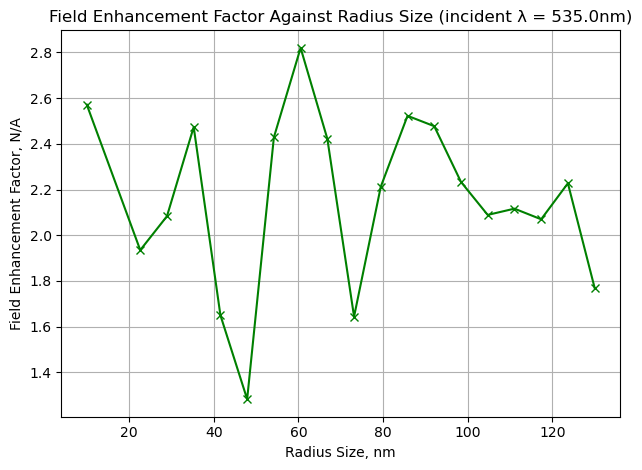

In [13]:
#Manual Plotting for varying radius

import numpy as np
import matplotlib.pyplot as plt

radii = np.array([
    10.0, 22.63157895, 28.94736842, 35.26315789,
    41.57894737, 47.89473684, 54.21052632, 60.52631579, 66.84210526,
    73.15789474, 79.47368421, 85.78947368, 92.10526316, 98.42105263,
    104.73684211, 111.05263158, 117.36842105, 123.68421053, 130.0
])

inc_field_vals = np.array([0.42, 0.46, 0.60, 0.57, 0.485, 0.425, 0.49, 0.5, 0.45,
                           0.435, 0.4, 0.44, 0.44, 0.45, 0.45, 0.43, 0.43, 0.44, 0.5
                          ])

enhanced_field_vals = np.array([1.08, 0.89, 1.25, 1.41, 0.8, 0.545, 1.19, 1.41, 1.09,
                               0.715, 0.885, 1.11, 1.09, 1.005, 0.94, 0.91, 0.89, 0.98, 0.885
                               ])


FEF_values = enhanced_field_vals / inc_field_vals

wvl = 535E-3

plt.figure()
plt.plot(radii, FEF_values, "x-g")
plt.grid(True, which="both", ls="-")
plt.xlabel("Radius Size, nm")
plt.ylabel("Field Enhancement Factor, N/A")
plt.title(f"Field Enhancement Factor Against Radius Size (incident λ = {wvl*1E3}nm)")
plt.tight_layout()

plt.savefig(fname="Field Enhancement Factor Against Radius Size",
            dpi=150, 
            bbox_inches="tight")
plt.show()
